# Downloading and importing important librarires

In [10]:
!pip install torchvision==0.20.1
!pip install torchaudio==2.5.1
!pip install torchdata==0.10.1
!pip install numpy==1.26.4

import torch
import torchvision
import torchvision.transforms as transforms
import torchaudio
import torchdata
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
os.makedirs("./data", exist_ok=True)


import random
import numpy as np

# Preparing data

In [11]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


# Flexible Neural Network class

In [12]:
class FlexibleNN(nn.Module):
    def __init__(self, hidden_layer_sizes):
        super(FlexibleNN, self).__init__()
        self.flatten = nn.Flatten()
        layers = []
        input_size = 28 * 28
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 10))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Data training and Evaluation

In [26]:
# Train and Evaluate Function
def train_and_evaluate(hidden_layer_sizes):
    model = FlexibleNN(hidden_layer_sizes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []

    for epoch in range(10):  # Train for a few epochs
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    return train_losses, test_losses

# Different Model Complexities

In [27]:

#  Experiment with Different Model Complexities
hidden_units = [16, 32, 64, 128, 256, 512, 1024, 2048]

train_loss_all = []
test_loss_all = []

for hidden_size in hidden_units:
    hidden_layer_sizes = [hidden_size, hidden_size, 16]
    train_losses, test_losses = train_and_evaluate(hidden_layer_sizes)
    train_loss_all.append(train_losses[-1])
    test_loss_all.append(test_losses[-1])

# Visualizing the results

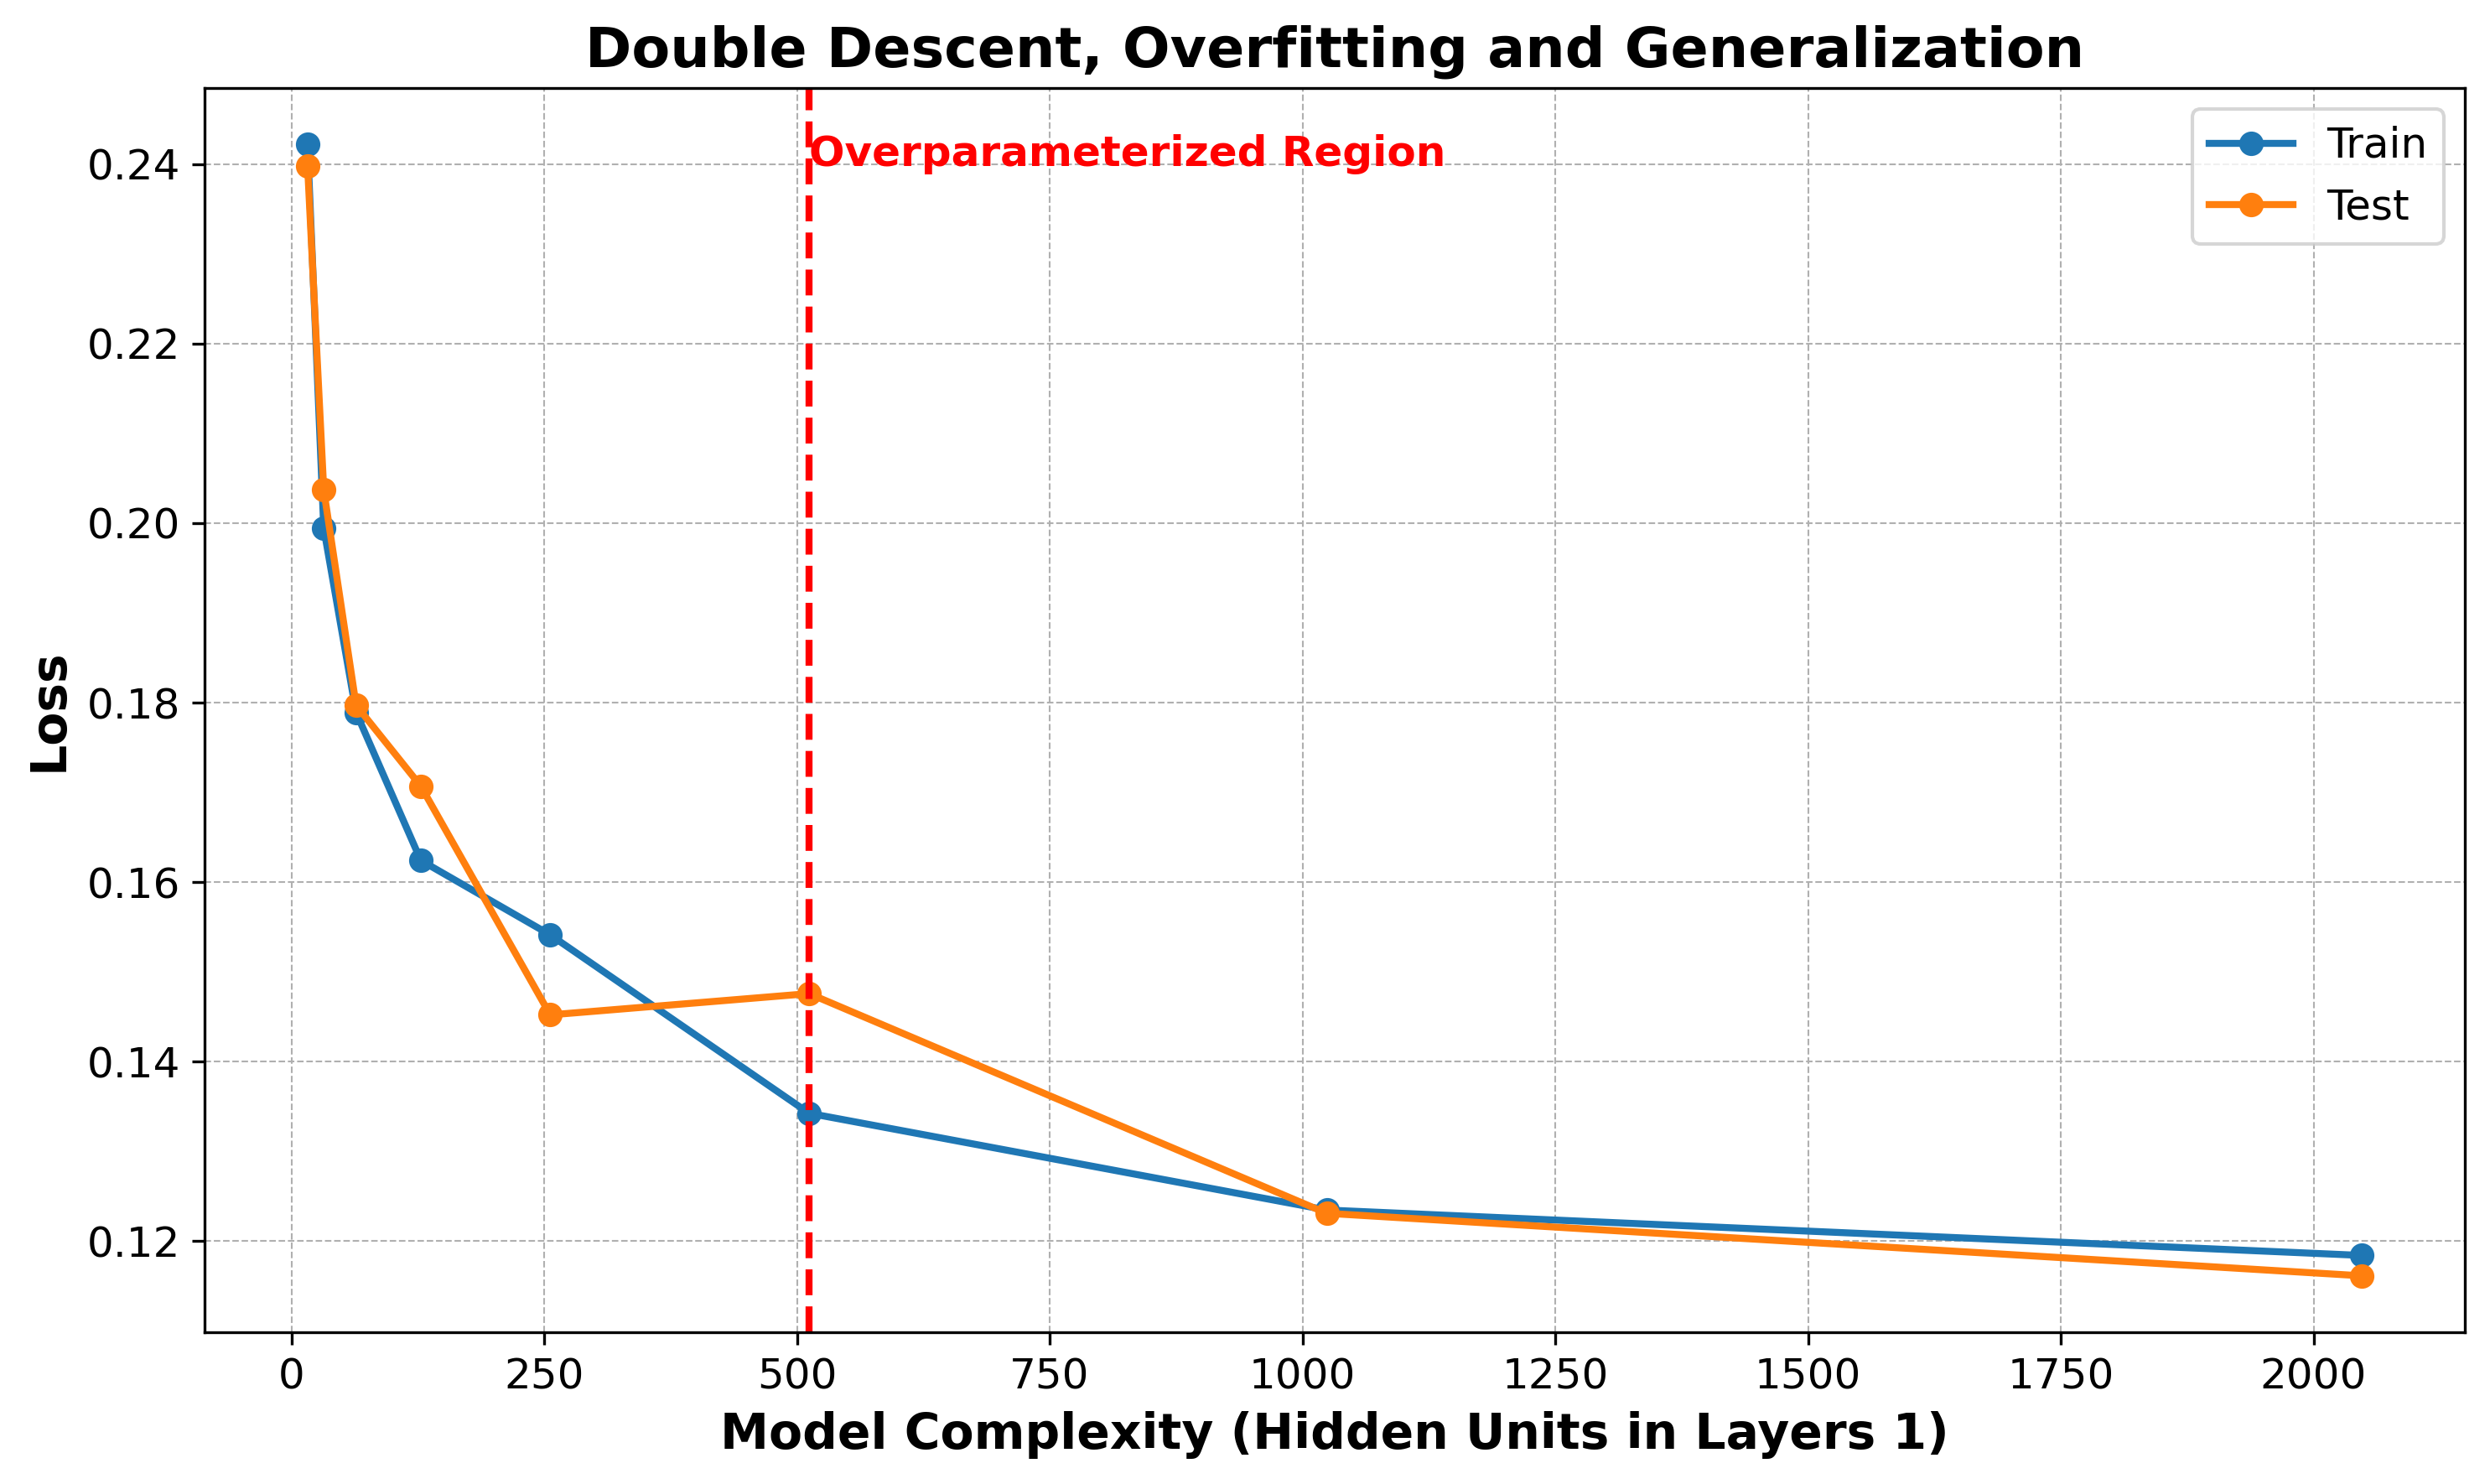

In [28]:
#  Plot Results
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(hidden_units, train_loss_all, label='Train', marker='o', linewidth=2, markersize=6)
plt.plot(hidden_units, test_loss_all, label='Test', marker='o', linewidth=2, markersize=6)
plt.xlabel('Model Complexity (Hidden Units in Layers 1)', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Double Descent, Overfitting and Generalization', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


overparameterized_index = next(i+1 for i in range(len(hidden_units)) if test_loss_all[i+1] > test_loss_all[i] and test_loss_all[i] < test_loss_all[i-1])
# add a vertical line for the overparameterized region
plt.axvline(x=hidden_units[overparameterized_index], color='red', linestyle='--', linewidth=2, label='Overparameterized Region')
plt.text(hidden_units[overparameterized_index], max(test_loss_all), 'Overparameterized Region', color='red', fontsize=12, fontweight='bold', ha='left')

plt.tight_layout()
plt.savefig('double_descent_plot.png', format='png', dpi=300)
plt.show()